## Imports

In [1]:
import cv2 as cv
import json
import matplotlib
import matplotlib.pyplot as plt
import torch
import glob

from torchvision.transforms import v2

#Ignore user warnings
import warnings
warnings.filterwarnings("ignore")

## Checking Annotations

In [2]:
# Read a JSON file
with open('data/Annotations/train.json') as f:
    trainJSON = json.load(f)

with open('data/Annotations/dev.json') as f:
    valJSON = json.load(f)

with open('data/Annotations/test.json') as f:
    testJSON = json.load(f)

In [3]:
classes = trainJSON['categories']

train_images = trainJSON['images']
val_images = valJSON['images']
test_images = testJSON['images']

train_annotations = trainJSON['annotations']
val_annotations = valJSON['annotations']
test_annotations = testJSON['annotations']

In [4]:
print('========= Classes =========')
display(classes)
print('========= Train images =========')
display(train_images[:2])
print('========= Train nnotations =========')
display(train_annotations[:2])

========= Classes =========


[{'id': 1, 'name': 'LE;ER', 'supercategory': None},
 {'id': 4, 'name': 'SF;PO', 'supercategory': None},
 {'id': 0, 'name': 'VG;MT', 'supercategory': None},
 {'id': 2, 'name': 'LR;DA', 'supercategory': None},
 {'id': 3, 'name': 'LE;CR', 'supercategory': None}]

========= Train images =========


[{'id': 0,
  'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/',
  'file_name': 'DJI_0058_1_3.JPG',
  'path': None,
  'width': 1024,
  'height': 1024,
  'depth': 3},
 {'id': 1,
  'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/',
  'file_name': 'DJI_0013_0_3.JPG',
  'path': None,
  'width': 1024,
  'height': 1024,
  'depth': 3}]

========= Train nnotations =========


[{'image_id': 0,
  'id': 0,
  'segmented': None,
  'bbox': [383.996928, 424.001024, 99.00032, 90.000384],
  'area': 8910.0668161229,
  'segmentation': None,
  'iscrowd': 0,
  'pose': None,
  'truncated': None,
  'category_id': 1,
  'difficult': None},
 {'image_id': 0,
  'id': 1,
  'segmented': None,
  'bbox': [616.001024, 20.00128, 45.999104, 47.000576],
  'area': 2161.9843834839,
  'segmentation': None,
  'iscrowd': 0,
  'pose': None,
  'truncated': None,
  'category_id': 4,
  'difficult': None}]

In [5]:
train_images_names = []
val_images_names = []
test_images_names = []

for metadata in train_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    train_images_names.append(img_name)

for metadata in val_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    val_images_names.append(img_name)

for metadata in test_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    test_images_names.append(img_name)

# Drop duplicates from the lists
train_images_names = list(set(train_images_names))
val_images_names = list(set(val_images_names))
test_images_names = list(set(test_images_names))

In [6]:
print('========= Train images names =========')
display(train_images_names[:11])
print('========= Validation images names =========')
display(val_images_names[:11])
print('========= Test images names =========')
display(test_images_names[:11])

========= Train images names =========


['DJI_0126.JPG',
 'DJI_0995.JPG',
 'DJI_0109.JPG',
 'DJI_0333.JPG',
 'DJI_0057.JPG',
 'DJI_0251.JPG',
 'DJI_0051.JPG',
 'DJI_0409.JPG',
 'DJI_0388.JPG',
 'DJI_0058.JPG',
 'DJI_0027.JPG']

========= Validation images names =========


['DJI_0329.JPG',
 'DJI_0006.JPG',
 'DJI_0101.JPG',
 'DJI_0697.JPG',
 'DJI_0171.JPG',
 'DJI_0708.JPG',
 'DJI_0119.JPG',
 'DJI_0106.JPG',
 'DJI_0331.JPG',
 'DJI_0121.JPG',
 'DJI_0185.JPG']

========= Test images names =========


['DJI_0184.JPG',
 'DJI_0703.JPG',
 'DJI_0206.JPG',
 'DJI_0169.JPG',
 'DJI_0026.JPG',
 'DJI_0694.JPG',
 'DJI_0170.JPG',
 'DJI_0434.JPG',
 'DJI_0433.JPG',
 'DJI_0201.JPG',
 'DJI_0157.JPG']

## Data Preparation

In [7]:
images = glob.glob('data/Images/*.JPG')

# Find the images that are in train_images_names in the images list, and then add them to a new list
train_images_paths = []
val_images_paths = []
test_images_paths = []

for img in images:
    if img[-12:] in train_images_names:
        train_images_paths.append(img)

    elif img[-12:] in val_images_names:
        val_images_paths.append(img)

    elif img[-12:] in test_images_names:
        test_images_paths.append(img)
        
    else: 
        continue

## Data Augmentation

In [8]:
# Create a class that creates a PyTorch dataset for all images in data/Nordtank 2017
class NordtankDataset(torch.utils.data.Dataset):
    def __init__(self, images_names, transform = None):
        self.images_names = images_names
        self.transform = transform

    def __len__(self):
        return len(self.images_names)

    def __getitem__(self, idx):
        img_name = self.images_names[idx]
        img_path = img_name
        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = torch.from_numpy(image.transpose(2, 0, 1))

        if self.transform:
            image = self.transform(image)
    
        image = image.permute(1, 2, 0)

        return image
    

def BeforeAfterDataAugmentation(aug_dataset, originals_dataset, idx):

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(originals_dataset[idx])
    axes[0].set_title('Before data augmentation')
    axes[1].imshow(aug_dataset[idx])
    axes[1].set_title('After data augmentation')

In [9]:
# Define the transformation pipeline
transform = v2.Compose([
                        v2.RandomHorizontalFlip(),  # Randomly flip the image horizontally
                        v2.RandomVerticalFlip(),    # Randomly flip the image vertically
                        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust brightness, contrast, saturation, and hue
                        v2.ToTensor(),               # Convert the image to a PyTorch tensor
                        ])

In [10]:
TrainAugmentationDataset, TrainOriginalDataset = NordtankDataset(train_images_paths, transform = transform), NordtankDataset(train_images_paths)
TrainDataset = torch.utils.data.ConcatDataset([TrainOriginalDataset, TrainAugmentationDataset])

ValDataset = NordtankDataset(val_images_paths)

TestDataset = NordtankDataset(test_images_paths)

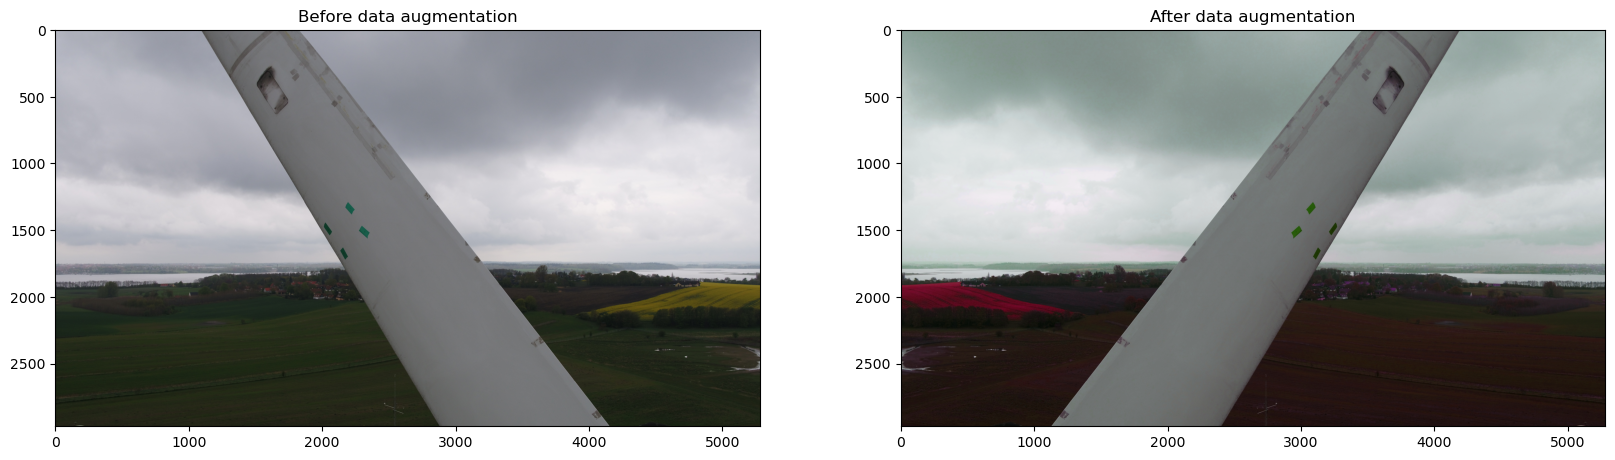

In [13]:
BeforeAfterDataAugmentation(TrainAugmentationDataset, TrainOriginalDataset, 0)

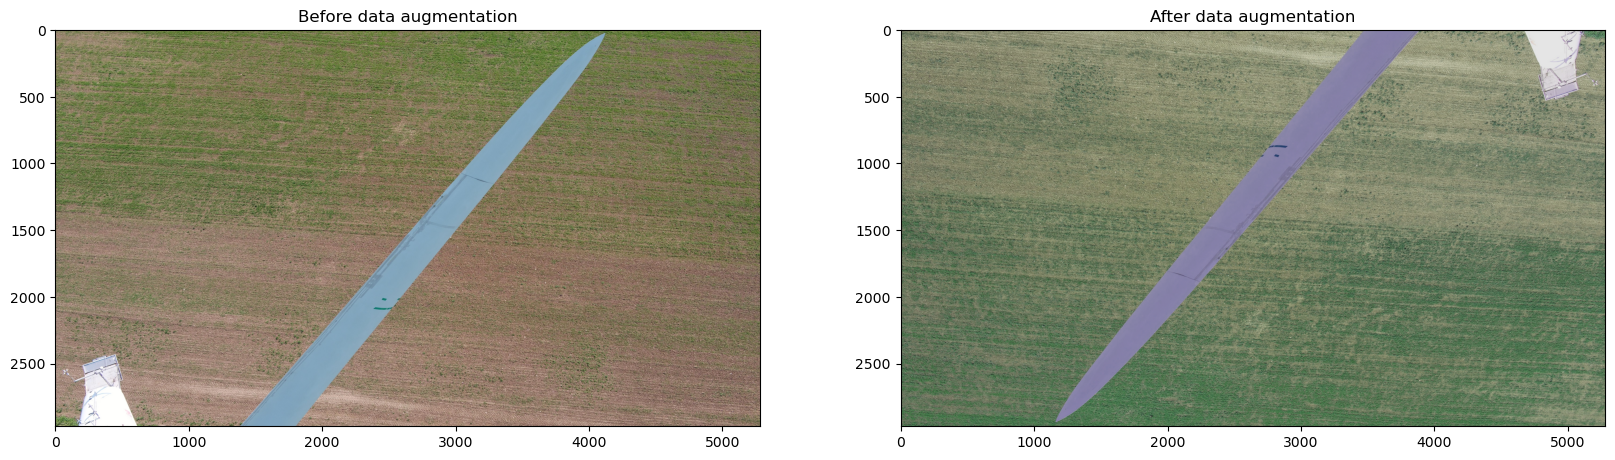

In [15]:
BeforeAfterDataAugmentation(TrainAugmentationDataset, TrainOriginalDataset, 50)

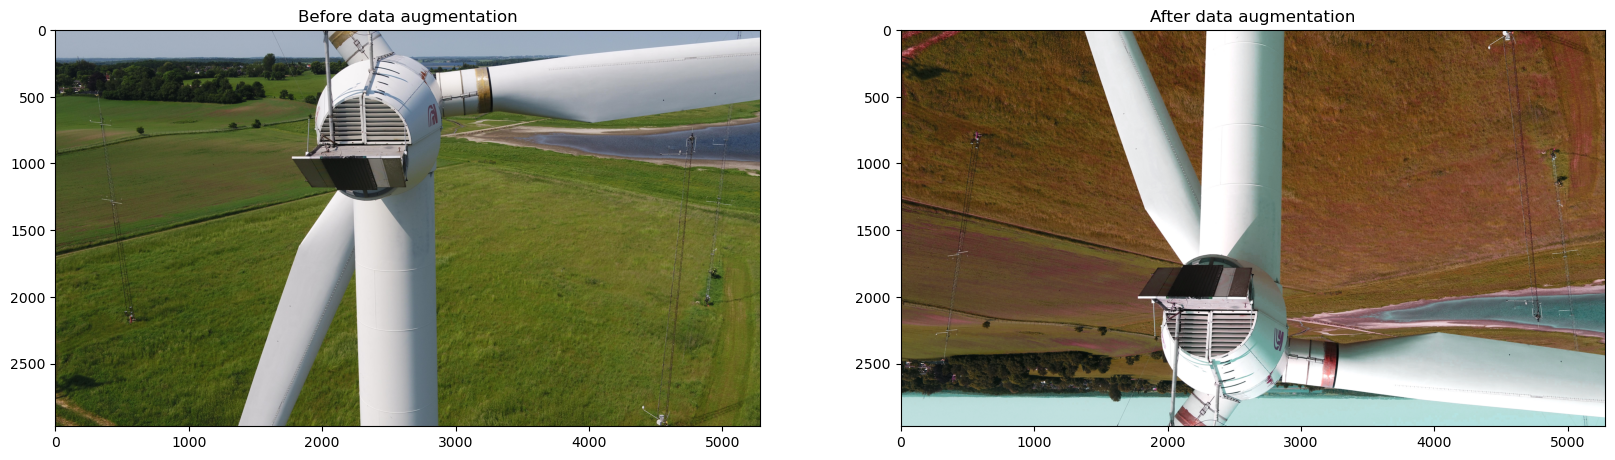

In [16]:
BeforeAfterDataAugmentation(TrainAugmentationDataset, TrainOriginalDataset, 100)

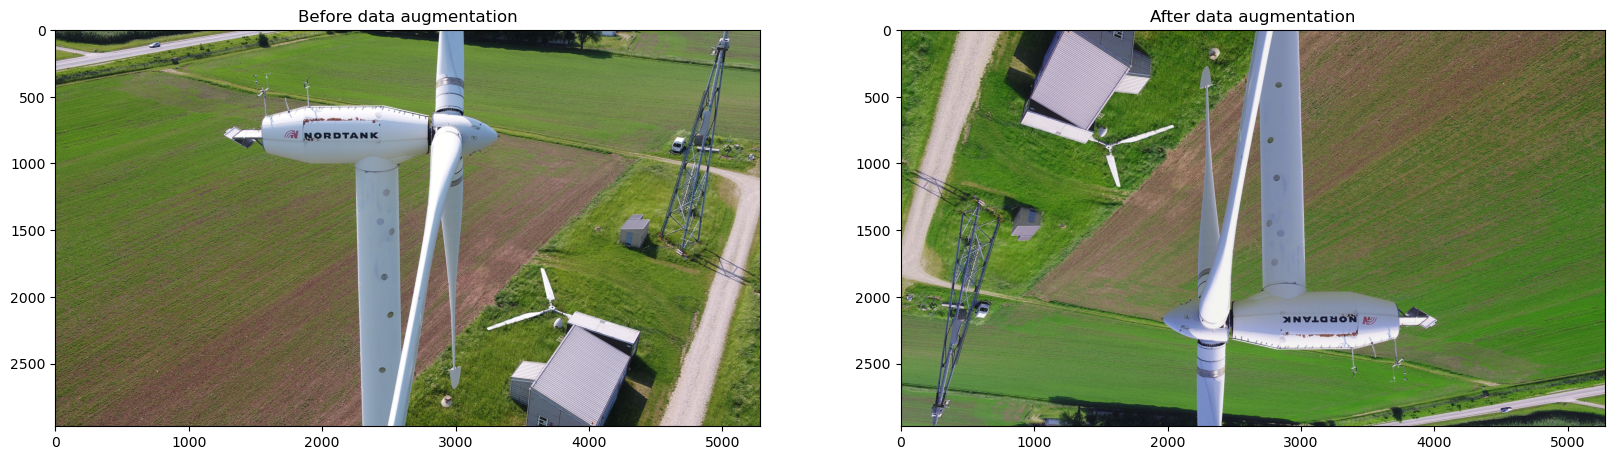

In [17]:
BeforeAfterDataAugmentation(TrainAugmentationDataset, TrainOriginalDataset, 150)

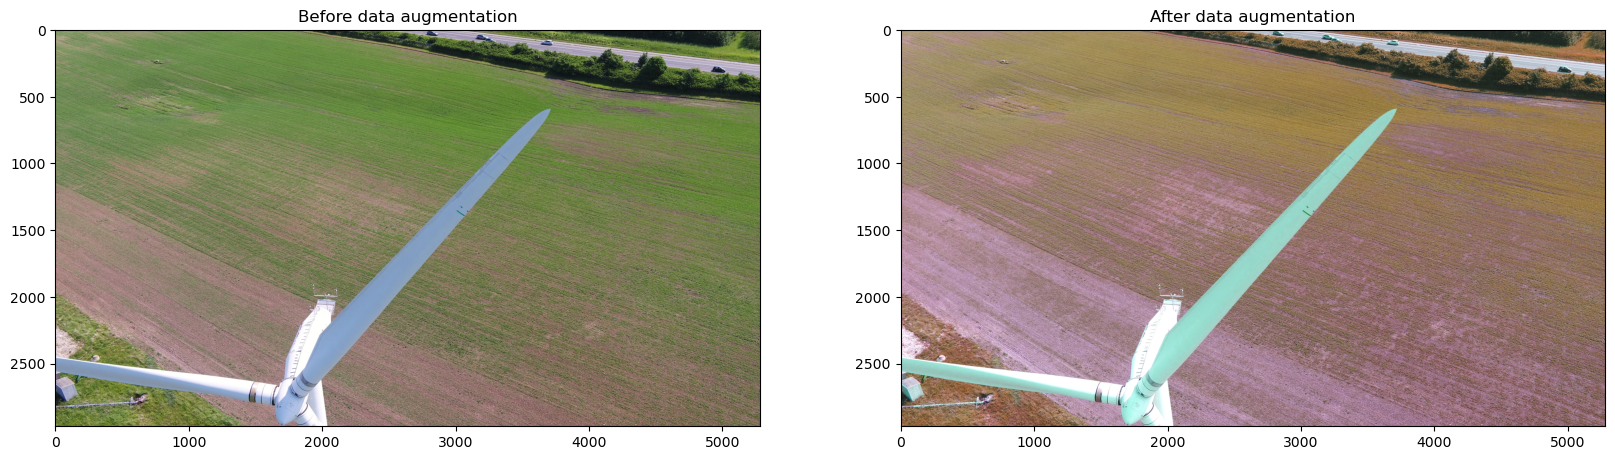

In [18]:
BeforeAfterDataAugmentation(TrainAugmentationDataset, TrainOriginalDataset, 200)

In [11]:
# Divide test_image into several images with 1024x1024 pixels excluding the sub-images that are not 1024x1024 pixels
def DivideImage(image, size):
    sub_images = []
    h, w, c = image.shape
    for i in range(0, h, size):
        for j in range(0, w, size):
            sub_images.append(image[i:i+size, j:j+size])

    # Remove the sub-images that are not 1024x1024 pixels
    sub_images = [sub_image for sub_image in sub_images if sub_image.shape == (size, size, c)]

    return sub_images


# Plot test image with red squares showing the sub-images
def PlotDividedImage(image, size):
    # image: a PyTorch tensor with shape (H, W, C)
    # size: the size of the sub-images (size x size)
    H, W, C = image.shape
    sub_images = DivideImage(image, size)
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i in range(0, H, size):
        for j in range(0, W, size):
            rect = matplotlib.patches.Rectangle((j, i), size, size, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.show()


# Plot the bounding box of the annotation in an image
def PlotBoundingBox(image, bbox):
    # image: a PyTorch tensor with shape (H, W, C)
    # annotation: a dictionary with the annotation of the image
    fig, ax = plt.subplots()
    ax.imshow(image)
    x, y, w, h = bbox
    rect = matplotlib.patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()


def CreateDatasetSubImages(dataset, dataframe, train_image_path_lst, size):
    sub_images = []
    sub_labels = []
    bboxes = []

    for image_name in dataframe['file_name'].unique():
        sub_images_df = dataframe[dataframe['file_name'] == image_name]
        sub_image_labels = [-1] * 10
        bboxes_sub_image = [None] * 10

        idx = train_image_path_lst.index('data/Images/' + image_name)
        image = dataset[idx]
        for index, sub_image in sub_images_df.iterrows():
            row = int(sub_image['sub_image_row'])
            col = int(sub_image['sub_image_col'])
            sub_image_labels[(row * 5) + col] = int(sub_image['category_id'])
            bboxes_sub_image[(row * 5) + col] = sub_image['bbox']

        sub_images += DivideImage(image, size)
        sub_labels += sub_image_labels
        bboxes += bboxes_sub_image
        
    return sub_images, sub_labels, bboxes

In [12]:
import pandas as pd

train_images_df = pd.DataFrame(train_images)
train_annotations_df = pd.DataFrame(train_annotations)

train_images_df.drop(columns = ['folder', 'path', 'width', 'height', 'depth'], inplace = True)
train_annotations_df.drop(columns = ['segmented', 'area', 'segmentation', 'iscrowd', 'pose', 'truncated', 'difficult'], inplace = True)

# Create two new columns in train_images_df that contain the row and column of the sub-image with the annotation
train_images_df['sub_image_row'] = train_images_df['file_name'].str[9:10].astype(int)
train_images_df['sub_image_col'] = train_images_df['file_name'].str[11:12].astype(int)
train_images_df['file_name'] = train_images_df['file_name'].str[:8] + train_images_df['file_name'].str[-4:]

#Change the name of the column "id" to "image_id" in the train_images_df
train_images_df.rename(columns = {'id': 'image_id'}, inplace = True)

# Merge train_images_df and train_annotations_df using the key "image_id"
train_df = pd.merge(train_images_df, train_annotations_df, on = 'image_id').drop(columns = ['id'])

# Delete all rows that have duplicate values in the columns "image_id", "sub_image_row", and "sub_image_col"
train_df.drop_duplicates(subset = ['image_id', 'sub_image_row', 'sub_image_col'], keep = False, inplace = True)

In [13]:
train_df

image_id     file_name  sub_image_row  sub_image_col  \
4           2  DJI_0013.JPG              1              1   
7           4  DJI_0168.JPG              0              4   
8           5  DJI_0168.JPG              1              2   
9           6  DJI_0131.JPG              1              1   
14          9  DJI_0700.JPG              0              1   
..        ...           ...            ...            ...   
548       415  DJI_0200.JPG              0              2   
549       416  DJI_0200.JPG              0              3   
550       417  DJI_0200.JPG              1              1   
553       419  DJI_0200.JPG              1              3   
558       422  DJI_0445.JPG              1              4   

                                                bbox  category_id  
4      [950.999552, 674.001408, 43.000832, 38.99904]            0  
7      [312.000512, 796.999168, 22.001664, 28.00128]            2  
8         [385.998336, 1.999872, 15.000576, 15.0016]            0  
9      [71.001088, 108.998656, 42.002432, 34.000896]            1  
14    [585.000448, 248.998912, 45.999104, 42.999808]            2  
..                                               ...          ...  
548    [949.00224, 1000.000512, 73.998336, 22.99904]            1  
549     [0.000512, 1000.000512, 14.001152, 22.99904]            1  
550  [978.999808, 770.999296, 44.000256, 111.998976]            1  
553            [0.000512, 0.0, 14.001152, 97.001472]            1  
558   [988.998656, 15.998976, 34.000896, 351.000576]            1  

[311 rows x 6 columns]

In [14]:
train_sub_images, train_sub_labels, bboxes = CreateDatasetSubImages(TrainDataset, train_df, train_images_paths, 1024)

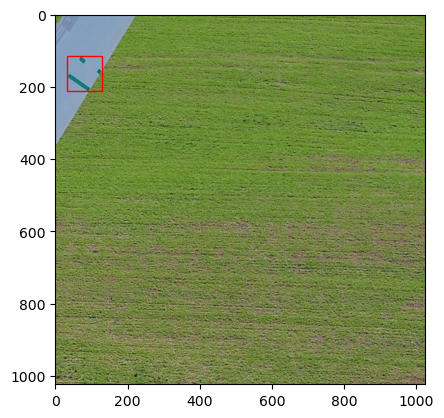

In [39]:
PlotBoundingBox(train_sub_images[1013], bboxes[1013])

In [41]:
# Print count of unique values in train_sub_labels
print('Count of unique values in train_sub_labels:')
print(pd.Series(train_sub_labels).value_counts())

Count of unique values in train_sub_labels:
-1    1529
 1     148
 0      88
 4      36
 3      28
 2      11
dtype: int64
